In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns

In [3]:
import json
import requests
import random

In [4]:
with open('../config.json', 'r') as f:
    config = json.load(f)

In [5]:
config[0].keys()
config[1].keys()
config[2].keys()

dict_keys(['threshold_nan'])

dict_keys(['database_path', 'prvdr_category_file', 'icd9_procedure_code_category_file', 'hcpcs_code_category_file', 'eda_report_location', 'model_repository_location'])

dict_keys(['ICD9_DIAGNOSIS_CODE_CATEGORY_URL', 'HCPCS_CATEGORY_URL'])

In [6]:
conn_object = sqlite3.connect(config[1]['database_path'])

In [7]:
data_inpatient_claims = pd.read_csv(
    f"..\input\DE1.0 Sample2\DE1_0_2008_to_2010_Inpatient_Claims_Sample_2.zip",)

# data_inpatient_claims = pd.read_sql_query("select * from InPatientData", con=conn_object)

In [8]:
data_inpatient_claims.head()
data_inpatient_claims.dtypes

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00000B48BCF4AD29,45461150060934,1,20080707.0,20080718.0,1000GD,57000.0,0.0,1.219278e+09,7.451661e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000B48BCF4AD29,45541150055035,1,20080724.0,20080726.0,1030RD,0.0,0.0,9.812675e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000B48BCF4AD29,45731150068478,1,20080805.0,20080820.0,1001NA,24000.0,0.0,6.035410e+09,9.404475e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000525AB30E4DEF,45811150057351,1,20080525.0,20080605.0,3900MB,4000.0,0.0,1.511429e+09,7.340276e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000525AB30E4DEF,45391150058019,1,20080918.0,20080924.0,3100JN,8000.0,0.0,3.198318e+09,9.156656e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DESYNPUF_ID     object
CLM_ID           int64
SEGMENT          int64
CLM_FROM_DT    float64
CLM_THRU_DT    float64
                ...   
HCPCS_CD_41    float64
HCPCS_CD_42    float64
HCPCS_CD_43    float64
HCPCS_CD_44    float64
HCPCS_CD_45    float64
Length: 81, dtype: object

# Checking the columns for NaN and dropping them if NaN are more than a threshold value

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    data_inpatient_claims.isna().sum()[data_inpatient_claims.isna().sum() > 0]/data_inpatient_claims.shape[0]

CLM_FROM_DT               0.000902
CLM_THRU_DT               0.000902
AT_PHYSN_NPI              0.010106
OP_PHYSN_NPI              0.416895
OT_PHYSN_NPI              0.883704
ADMTNG_ICD9_DGNS_CD       0.008978
NCH_BENE_IP_DDCTBL_AMT    0.033386
CLM_UTLZTN_DAY_CNT        0.000902
ICD9_DGNS_CD_1            0.001354
ICD9_DGNS_CD_2            0.007805
ICD9_DGNS_CD_3            0.018633
ICD9_DGNS_CD_4            0.040169
ICD9_DGNS_CD_5            0.075721
ICD9_DGNS_CD_6            0.125229
ICD9_DGNS_CD_7            0.184122
ICD9_DGNS_CD_8            0.250414
ICD9_DGNS_CD_9            0.321593
ICD9_DGNS_CD_10           0.919211
ICD9_PRCDR_CD_1           0.429332
ICD9_PRCDR_CD_2           0.660676
ICD9_PRCDR_CD_3           0.785424
ICD9_PRCDR_CD_4           0.860589
ICD9_PRCDR_CD_5           0.905014
ICD9_PRCDR_CD_6           0.932144
HCPCS_CD_1                1.000000
HCPCS_CD_2                1.000000
HCPCS_CD_3                1.000000
HCPCS_CD_4                1.000000
HCPCS_CD_5          

As seen above, lots of columns have NaN values. Lets drop the columns which has more than 60% NaN value

In [10]:
not_nan_threshold = config[0]['threshold_nan']

In [11]:
data_inpatient_claims.dropna(thresh=data_inpatient_claims.shape[0]*not_nan_threshold, how='all', axis=1, inplace=True)

In [12]:
#columns that are remaining
data_inpatient_claims.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_PRCDR_CD_1'],
      dtype='object')

# Checking and correcting dtypes of features

In [13]:
# Lets check the datatype of remaining columns
data_inpatient_claims.dtypes

DESYNPUF_ID                        object
CLM_ID                              int64
SEGMENT                             int64
CLM_FROM_DT                       float64
CLM_THRU_DT                       float64
PRVDR_NUM                          object
CLM_PMT_AMT                       float64
NCH_PRMRY_PYR_CLM_PD_AMT          float64
AT_PHYSN_NPI                      float64
OP_PHYSN_NPI                      float64
CLM_ADMSN_DT                        int64
ADMTNG_ICD9_DGNS_CD                object
CLM_PASS_THRU_PER_DIEM_AMT        float64
NCH_BENE_IP_DDCTBL_AMT            float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM    float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    float64
CLM_UTLZTN_DAY_CNT                float64
NCH_BENE_DSCHRG_DT                  int64
CLM_DRG_CD                         object
ICD9_DGNS_CD_1                     object
ICD9_DGNS_CD_2                     object
ICD9_DGNS_CD_3                     object
ICD9_DGNS_CD_4                     object
ICD9_DGNS_CD_5                    

Since we know that NPI numbers are 10 digit integer encoding physician identification, lets make them as category.

In [14]:
data_inpatient_claims.astype({"AT_PHYSN_NPI" : "category", "OP_PHYSN_NPI" : "category",}).dtypes

DESYNPUF_ID                         object
CLM_ID                               int64
SEGMENT                              int64
CLM_FROM_DT                        float64
CLM_THRU_DT                        float64
PRVDR_NUM                           object
CLM_PMT_AMT                        float64
NCH_PRMRY_PYR_CLM_PD_AMT           float64
AT_PHYSN_NPI                      category
OP_PHYSN_NPI                      category
CLM_ADMSN_DT                         int64
ADMTNG_ICD9_DGNS_CD                 object
CLM_PASS_THRU_PER_DIEM_AMT         float64
NCH_BENE_IP_DDCTBL_AMT             float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM     float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM     float64
CLM_UTLZTN_DAY_CNT                 float64
NCH_BENE_DSCHRG_DT                   int64
CLM_DRG_CD                          object
ICD9_DGNS_CD_1                      object
ICD9_DGNS_CD_2                      object
ICD9_DGNS_CD_3                      object
ICD9_DGNS_CD_4                      object
ICD9_DGNS_C

In [15]:
data_inpatient_claims.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_PRCDR_CD_1
0,00000B48BCF4AD29,45461150060934,1,20080707.0,20080718.0,1000GD,57000.0,0.0,1.219278e+09,7.451661e+09,...,4241,2760,7802,2763,42821,2762,41410,3970,5119,3521.0
1,00000B48BCF4AD29,45541150055035,1,20080724.0,20080726.0,1030RD,0.0,0.0,9.812675e+09,NaN,...,42823,2859,5119,56400,4263,V4582,3051,25060,4280,NaN
2,00000B48BCF4AD29,45731150068478,1,20080805.0,20080820.0,1001NA,24000.0,0.0,6.035410e+09,9.404475e+09,...,3970,2800,9971,41410,V4581,2875,5121,4242,42731,3615.0
3,0000525AB30E4DEF,45811150057351,1,20080525.0,20080605.0,3900MB,4000.0,0.0,1.511429e+09,7.340276e+09,...,5609,42732,V4579,V4501,79902,2762,53081,51881,5533,9915.0
4,0000525AB30E4DEF,45391150058019,1,20080918.0,20080924.0,3100JN,8000.0,0.0,3.198318e+09,9.156656e+09,...,5579,V4611,5849,99591,42731,4019,78550,53550,7837,3898.0


Looks like the dates are in the float format. Converting them all to datatime objects

In [16]:
data_inpatient_claims["CLM_FROM_DT"] = pd.to_datetime(
    data_inpatient_claims["CLM_FROM_DT"], format="%Y%m%d"
)
data_inpatient_claims["CLM_THRU_DT"] = pd.to_datetime(
    data_inpatient_claims["CLM_THRU_DT"], format="%Y%m%d"
)

data_inpatient_claims["CLM_ADMSN_DT"] = pd.to_datetime(
    data_inpatient_claims["CLM_ADMSN_DT"], format="%Y%m%d"
)
data_inpatient_claims["NCH_BENE_DSCHRG_DT"] = pd.to_datetime(
    data_inpatient_claims["NCH_BENE_DSCHRG_DT"], format="%Y%m%d"
)

In [17]:
data_inpatient_claims.head()
data_inpatient_claims.columns
data_inpatient_claims.shape

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_PRCDR_CD_1
0,00000B48BCF4AD29,45461150060934,1,2008-07-07,2008-07-18,1000GD,57000.0,0.0,1.219278e+09,7.451661e+09,...,4241,2760,7802,2763,42821,2762,41410,3970,5119,3521.0
1,00000B48BCF4AD29,45541150055035,1,2008-07-24,2008-07-26,1030RD,0.0,0.0,9.812675e+09,NaN,...,42823,2859,5119,56400,4263,V4582,3051,25060,4280,NaN
2,00000B48BCF4AD29,45731150068478,1,2008-08-05,2008-08-20,1001NA,24000.0,0.0,6.035410e+09,9.404475e+09,...,3970,2800,9971,41410,V4581,2875,5121,4242,42731,3615.0
3,0000525AB30E4DEF,45811150057351,1,2008-05-25,2008-06-05,3900MB,4000.0,0.0,1.511429e+09,7.340276e+09,...,5609,42732,V4579,V4501,79902,2762,53081,51881,5533,9915.0
4,0000525AB30E4DEF,45391150058019,1,2008-09-18,2008-09-24,3100JN,8000.0,0.0,3.198318e+09,9.156656e+09,...,5579,V4611,5849,99591,42731,4019,78550,53550,7837,3898.0


Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_PRCDR_CD_1'],
      dtype='object')

(66494, 29)

# Categorizing PROVIDER NUM

In [18]:
prvdr_num_categories = pd.read_csv(config[1]["prvdr_category_file"])
prvdr_num_categories.head()

,PRVDR_CAT
0,0001-0879
1,0880-0899
2,0900-0999
3,1000-1199
4,1200-1224


In [19]:
prvdr_num_bins = [cat for cat in prvdr_num_categories['PRVDR_CAT'].str.strip().str.split("-") if len(cat) > 1]

In [20]:
prvdr_num_bins

[['0001', '0879'],
 ['0880', '0899'],
 ['0900', '0999'],
 ['1000', '1199'],
 ['1200', '1224'],
 ['1225', '1299'],
 ['1300', '1399'],
 ['1400', '1499'],
 ['1500', '1799'],
 ['1800', '1989'],
 ['1990', '1999'],
 ['2000', '2299'],
 ['2300', '2499'],
 ['2500', '2899'],
 ['2900', '2999'],
 ['3000', '3024'],
 ['3025', '3099'],
 ['3100', '3199'],
 ['3200', '3299'],
 ['3300', '3399'],
 ['3400', '3499'],
 ['3500', '3699'],
 ['3700', '3799'],
 ['3800', '3974'],
 ['3975', '3999'],
 ['4000', '4499'],
 ['4500', '4599'],
 ['4600', '4799'],
 ['4800', '4899'],
 ['4900', '4999'],
 ['5000', '6499'],
 ['6500', '6989'],
 ['6990', '6999'],
 ['7000', '7299'],
 ['7300', '7399'],
 ['7400', '7799'],
 ['7800', '7999'],
 ['8000', '8499'],
 ['8500', '8899'],
 ['8900', '8999'],
 ['9000', '9799'],
 ['9800', '9899']]

In [21]:
unique_prvdr_num = pd.DataFrame(data_inpatient_claims['PRVDR_NUM'].unique(), columns=["PRVDR_NUM"])
unique_prvdr_num

,PRVDR_NUM
0,1000GD
1,1030RD
2,1001NA
3,3900MB
4,3100JN
...,...
2699,1030NA
2700,4500UA
2701,2600TM
2702,0501NB


In [22]:
def categorize_prvdr_num(prvdr_num):
    if str(prvdr_num)[2].isalpha():
        return str(prvdr_num)[2]
    else :
        for lower, upper in prvdr_num_bins:
            if lower <= prvdr_num[ : -2] <= upper:
                return f'{lower}-{upper}'

In [23]:
unique_prvdr_num['PRVDR_NUM_CAT'] = unique_prvdr_num['PRVDR_NUM'].apply(lambda x : categorize_prvdr_num(x))

In [24]:
data_inpatient_claims = data_inpatient_claims.merge(right=unique_prvdr_num, on=["PRVDR_NUM"], how="left")

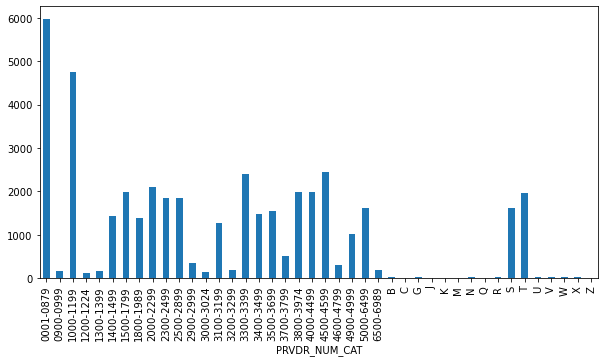

In [25]:
data_inpatient_claims[["DESYNPUF_ID", "PRVDR_NUM_CAT"]].drop_duplicates().groupby(["PRVDR_NUM_CAT"])["DESYNPUF_ID"].size().plot(kind='bar', figsize=(10,5))

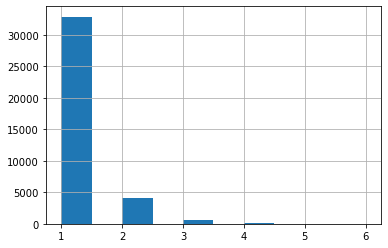

In [26]:
data_inpatient_claims[["DESYNPUF_ID", "PRVDR_NUM_CAT"]].drop_duplicates().groupby(["DESYNPUF_ID"])["PRVDR_NUM_CAT"].size().sort_values(ascending=False).hist()

<h2> Creating list of columns for diagnosis, procedure & hcpcs code </h2> 

In [27]:
# data_inpatient_claims_2["ADMTNG_ICD9_DGNS_CD_DESC"] = data_inpatient_claims_2['ADMTNG_ICD9_DGNS_CD'].apply(lamda x : fetch_diagnosis.get_description_for_icd_code(codeType="icd9cm", ICD9Codes=x))
diagnosis_code = [col for col in data_inpatient_claims.columns if "ICD9_DGNS" in col]
icd_procedural_code = [col for col in data_inpatient_claims.columns if "ICD9_PRCDR" in col]
icd_hcpcs_code = [col for col in data_inpatient_claims.columns if "HCPCS_CD" in col]

# Categorizing ICD9 Diagnosis Code

In [28]:
response = requests.get(config[2]["ICD9_DIAGNOSIS_CODE_CATEGORY_URL"], verify=False)

In [29]:
icd_code_categories = pd.read_html(response.text)[0]

In [30]:
for col in diagnosis_code:
    data_inpatient_claims[col] = data_inpatient_claims[col].str[ : 3]
    data_inpatient_claims[col].astype(str).replace('nan',np.nan)

0        428
1        428
2        786
3        560
4        789
        ... 
66489    786
66490    285
66491    786
66492    780
66493    432
Name: ADMTNG_ICD9_DGNS_CD, Length: 66494, dtype: object

0        424
1        428
2        397
3        560
4        557
        ... 
66489    491
66490    537
66491    786
66492    458
66493    432
Name: ICD9_DGNS_CD_1, Length: 66494, dtype: object

0        276
1        285
2        280
3        427
4        V46
        ... 
66489    790
66490    197
66491    428
66492    V43
66493    427
Name: ICD9_DGNS_CD_2, Length: 66494, dtype: object

0        780
1        511
2        997
3        V45
4        584
        ... 
66489    305
66490    518
66491    414
66492    786
66493    272
Name: ICD9_DGNS_CD_3, Length: 66494, dtype: object

0        276
1        564
2        414
3        V45
4        995
        ... 
66489    250
66490    799
66491    780
66492    401
66493    277
Name: ICD9_DGNS_CD_4, Length: 66494, dtype: object

0        428
1        426
2        V45
3        799
4        427
        ... 
66489    V10
66490    278
66491    300
66492    V45
66493    784
Name: ICD9_DGNS_CD_5, Length: 66494, dtype: object

0        276
1        V45
2        287
3        276
4        401
        ... 
66489    733
66490    414
66491    272
66492    V45
66493    787
Name: ICD9_DGNS_CD_6, Length: 66494, dtype: object

0        414
1        305
2        512
3        530
4        785
        ... 
66489    244
66490    692
66491    NaN
66492    331
66493    518
Name: ICD9_DGNS_CD_7, Length: 66494, dtype: object

0        397
1        250
2        424
3        518
4        535
        ... 
66489    403
66490    428
66491    NaN
66492    801
66493    428
Name: ICD9_DGNS_CD_8, Length: 66494, dtype: object

0        511
1        428
2        427
3        553
4        783
        ... 
66489    V58
66490    280
66491    NaN
66492    458
66493    V45
Name: ICD9_DGNS_CD_9, Length: 66494, dtype: object

In [31]:
icd_diagnosis_code_bin = [x for x in icd_code_categories['Code Range'].str.split("-")]
icd_diagnosis_code_categories = icd_code_categories['Code Range'].tolist()

In [32]:
icd_code_categories

,Chapter,Code Range,Description
0,1,001-139,Infectious And Parasitic Diseases
1,2,140-239,Neoplasms
2,3,240-279,"Endocrine, Nutritional And Metabolic Diseases,..."
3,4,280-289,Diseases Of The Blood And Blood-Forming Organs
4,5,290-319,Mental Disorders
5,6,320-389,Diseases Of The Nervous System And Sense Organs
6,7,390-459,Diseases Of The Circulatory System
7,8,460-519,Diseases Of The Respiratory System
8,9,520-579,Diseases Of The Digestive System
9,10,580-629,Diseases Of The Genitourinary System


In [33]:
data_inpatient_claims[diagnosis_code].isna().sum()

ADMTNG_ICD9_DGNS_CD      597
ICD9_DGNS_CD_1            90
ICD9_DGNS_CD_2           519
ICD9_DGNS_CD_3          1239
ICD9_DGNS_CD_4          2671
ICD9_DGNS_CD_5          5035
ICD9_DGNS_CD_6          8327
ICD9_DGNS_CD_7         12243
ICD9_DGNS_CD_8         16651
ICD9_DGNS_CD_9         21384
dtype: int64

In [34]:
diagnosis_code_df = pd.DataFrame()
for col in diagnosis_code:
    diagnosis_code_df = pd.concat([diagnosis_code_df, pd.DataFrame(data_inpatient_claims[col].values)], axis=0)

In [35]:
unique_diagnosis_code = pd.DataFrame(diagnosis_code_df[0].unique(), columns=['Diagnosis_code'])
unique_diagnosis_code

,Diagnosis_code
0,428
1,786
2,560
3,789
4,486
...,...
865,083
866,077
867,927
868,633


In [36]:
def categorize_diagnosis_code (icd_diagnosis_code):
    if pd.isnull(icd_diagnosis_code) :
        return np.nan
    elif "E" in str(icd_diagnosis_code):
        return "E000-E999"
    elif "V" in str(icd_diagnosis_code):
        return "V01-V91"
    elif "OTH" in str(icd_diagnosis_code):
        return "OTHER"
    else:
        for lower, upper in icd_diagnosis_code_bin[ : -2]:
            if all([icd_diagnosis_code.isnumeric(), lower.isnumeric(), upper.isnumeric()]) & (lower <= icd_diagnosis_code <= upper):
                return f'{lower}-{upper}'

In [37]:
unique_diagnosis_code["Diagnosis_code_CAT"] = unique_diagnosis_code["Diagnosis_code"].apply(categorize_diagnosis_code)

In [38]:
unique_diagnosis_code

,Diagnosis_code,Diagnosis_code_CAT
0,428,390-459
1,786,780-799
2,560,520-579
3,789,780-799
4,486,460-519
...,...,...
865,083,001-139
866,077,001-139
867,927,800-999
868,633,630-679


In [39]:
for cols in diagnosis_code:
    data_inpatient_claims[f'{cols}_CAT'] = pd.merge(left=data_inpatient_claims, right=unique_diagnosis_code, left_on=cols, right_on="Diagnosis_code", how='left')['Diagnosis_code_CAT']

In [40]:
diagnosis_code_cat = [col for col in data_inpatient_claims.columns if "CAT" in col]

In [41]:
data_inpatient_claims[diagnosis_code + diagnosis_code_cat]

,ADMTNG_ICD9_DGNS_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,...,ADMTNG_ICD9_DGNS_CD_CAT,ICD9_DGNS_CD_1_CAT,ICD9_DGNS_CD_2_CAT,ICD9_DGNS_CD_3_CAT,ICD9_DGNS_CD_4_CAT,ICD9_DGNS_CD_5_CAT,ICD9_DGNS_CD_6_CAT,ICD9_DGNS_CD_7_CAT,ICD9_DGNS_CD_8_CAT,ICD9_DGNS_CD_9_CAT
0,428,424,276,780,276,428,276,414,397,511,...,390-459,390-459,240-279,780-799,240-279,390-459,240-279,390-459,390-459,460-519
1,428,428,285,511,564,426,V45,305,250,428,...,390-459,390-459,280-289,460-519,520-579,390-459,V01-V91,290-319,240-279,390-459
2,786,397,280,997,414,V45,287,512,424,427,...,780-799,390-459,280-289,800-999,390-459,V01-V91,280-289,460-519,390-459,390-459
3,560,560,427,V45,V45,799,276,530,518,553,...,520-579,520-579,390-459,V01-V91,V01-V91,780-799,240-279,520-579,460-519,520-579
4,789,557,V46,584,995,427,401,785,535,783,...,780-799,520-579,V01-V91,580-629,800-999,390-459,390-459,780-799,520-579,780-799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66489,786,491,790,305,250,V10,733,244,403,V58,...,780-799,460-519,780-799,290-319,240-279,V01-V91,710-739,240-279,390-459,V01-V91
66490,285,537,197,518,799,278,414,692,428,280,...,280-289,520-579,140-239,460-519,780-799,240-279,390-459,680-709,390-459,280-289
66491,786,786,428,414,780,300,272,NaN,NaN,NaN,...,780-799,780-799,390-459,390-459,780-799,290-319,240-279,NaN,NaN,NaN
66492,780,458,V43,786,401,V45,V45,331,801,458,...,780-799,390-459,V01-V91,780-799,390-459,V01-V91,V01-V91,320-389,800-999,390-459


# Processing the ICD9 Procedural code

> Slicing all the icd_procedural_code columns to only first two character

> Creating a list of the upper and lower value of each categories 

> Creating a new dataframe to store all the unique icd9 procedural code in the dataset

> Apply function to create categories for all the unique icd9 procedure code

> Merge the categories into the original dataset using left join

In [42]:
data_inpatient_claims.loc[ : , icd_procedural_code] = data_inpatient_claims.loc[ :, icd_procedural_code].astype('str')

for col in icd_procedural_code:
    data_inpatient_claims.loc[data_inpatient_claims[col].str.contains('nan'), icd_procedural_code] = np.nan

In [43]:
procedural_code_mapping = pd.read_csv(config[1]["icd9_procedure_code_category_file"], encoding='utf-8')

In [44]:
data_inpatient_claims['ICD9_PRCDR_CD_1'].value_counts()/data_inpatient_claims.shape[0]

9904.0    0.028288
8154.0    0.024183
3893.0    0.022152
3995.0    0.020092
66.0      0.019987
            ...   
8594.0    0.000015
5297.0    0.000015
8414.0    0.000015
5194.0    0.000015
8394.0    0.000015
Name: ICD9_PRCDR_CD_1, Length: 1285, dtype: float64

In [45]:
procedural_code_mapping

,Code Range,Description
0,00-00,"Procedures And Interventions , Not Elsewhere C..."
1,01-05,Operations On The Nervous System
2,06-07,Operations On The Endocrine System
3,08-16,Operations On The Eye
4,17-17,Other Miscellaneous Diagnostic And Therapeutic...
5,18-20,Operations On The Ear
6,21-29,"Operations On The Nose, Mouth, And Pharynx"
7,30-34,Operations On The Respiratory System
8,35-39,Operations On The Cardiovascular System
9,40-41,Operations On The Hemic And Lymphatic System


In [46]:
icd_procedure_code_bin = [x for x in procedural_code_mapping['Code Range'].str.strip().str.split("-")]
icd_procedure_code_categories = icd_code_categories['Code Range'].tolist()

In [47]:
icd_procedure_code_bin

[['00', '00'],
 ['01', '05'],
 ['06', '07'],
 ['08', '16'],
 ['17', '17'],
 ['18', '20'],
 ['21', '29'],
 ['30', '34'],
 ['35', '39'],
 ['40', '41'],
 ['42', '54'],
 ['55', '59'],
 ['60', '64'],
 ['65', '71'],
 ['72', '75'],
 ['76', '84'],
 ['85', '86'],
 ['87', '99']]

In [48]:
for col in icd_procedural_code:
    data_inpatient_claims.loc[ :, col] = data_inpatient_claims.loc[ :, col].str[ : 2]

In [49]:
procedure_code_df = pd.DataFrame()
for col in icd_procedural_code:
    procedure_code_df = pd.concat([procedure_code_df, pd.DataFrame(data_inpatient_claims[col].values)], axis=0)

In [50]:
unique_procedure_code = pd.DataFrame(procedure_code_df[0].unique(), columns=['Procedure_code'])
unique_procedure_code

,Procedure_code
0,35
1,NaN
2,36
3,99
4,38
...,...
83,28
84,67
85,25
86,75


In [51]:
def categorize_procedure_code(procedure_code):
    if pd.isnull(procedure_code) :
        return np.nan
    else :
        for lower, upper in icd_procedure_code_bin:
            if (lower <= procedure_code <= upper):
                return f'{lower}-{upper}'

In [52]:
unique_procedure_code.loc[ : , "Procedure_code_CAT"] = unique_procedure_code["Procedure_code"].apply(lambda x : categorize_procedure_code(x))

In [53]:
for col in icd_procedural_code:
    data_inpatient_claims[f'{col}_CAT'] = pd.merge(left=data_inpatient_claims, right=unique_procedure_code, left_on=col, right_on="Procedure_code", how='left')['Procedure_code_CAT']

In [54]:
data_inpatient_claims['ICD9_PRCDR_CD_1_CAT'].value_counts(dropna=False)

NaN      28548
87-99     9633
35-39     8181
76-84     6383
42-54     6173
30-34     1918
65-71     1893
85-86     1234
55-59     1007
60-64      527
40-41      271
08-16      242
21-29      219
17-17      152
72-75       95
18-20       18
Name: ICD9_PRCDR_CD_1_CAT, dtype: int64

# Creating Year column

In [55]:
data_inpatient_claims.loc[ : , 'CLAIM_YEAR'] = data_inpatient_claims['CLM_ADMSN_DT'].dt.year

# Selecting disease category

> selecting rows that contain the disease category in any one of the icd1-icd9 column

> finding the readmission count for the disease category

> the category with most balanced class proportion is selected for further analysis

In [56]:
for cat in icd_code_categories['Code Range']:
    print("*"*50 + " "+ cat + " " + "*"*50)
    selected_data = data_inpatient_claims.loc[data_inpatient_claims[diagnosis_code_cat].isin([cat]).any(axis=1), : ]
    selected_data.loc[ :, 'Next_CLM_ADMSN_DT'] = selected_data.groupby("DESYNPUF_ID")['CLM_ADMSN_DT'].shift(-1)
    selected_data.loc[ :, 'Readmission_Day_Count'] = (selected_data['Next_CLM_ADMSN_DT'] - selected_data['NCH_BENE_DSCHRG_DT']).apply(lambda x: x.days)
    selected_data.loc[ :, 'IsReadmitted'] = (selected_data['Readmission_Day_Count'] <= 30) * 1
    print(selected_data['IsReadmitted'].value_counts())
    print(selected_data['IsReadmitted'].value_counts()/selected_data.shape[0])

************************************************** 001-139 **************************************************
0    10820
1      362
Name: IsReadmitted, dtype: int64
0    0.967627
1    0.032373
Name: IsReadmitted, dtype: float64
************************************************** 140-239 **************************************************
0    9644
1     246
Name: IsReadmitted, dtype: int64
0    0.975126
1    0.024874
Name: IsReadmitted, dtype: float64
************************************************** 240-279 **************************************************
0    41831
1     4249
Name: IsReadmitted, dtype: int64
0    0.907791
1    0.092209
Name: IsReadmitted, dtype: float64
************************************************** 280-289 **************************************************
0    15404
1      529
Name: IsReadmitted, dtype: int64
0    0.966798
1    0.033202
Name: IsReadmitted, dtype: float64
************************************************** 290-319 *******************************

In [57]:
# selecting desease as 390-459 or Desease of Circulatory system since it has maximum data
selected_icd_code = '390-459'
selected_data = data_inpatient_claims.loc[data_inpatient_claims[diagnosis_code_cat].isin([selected_icd_code]).any(axis=1), : ].copy()

# Generating target variable

In [58]:
# Calculating the previous discharge date for the patient
selected_data.loc[ : , ['DESYNPUF_ID', 'CLM_ID', 'CLM_ADMSN_DT', 'NCH_BENE_DSCHRG_DT']]
selected_data.loc[ :, 'Next_CLM_ADMSN_DT'] = selected_data.groupby("DESYNPUF_ID")['CLM_ADMSN_DT'].shift(-1)

,DESYNPUF_ID,CLM_ID,CLM_ADMSN_DT,NCH_BENE_DSCHRG_DT
0,00000B48BCF4AD29,45461150060934,2008-07-07,2008-07-18
1,00000B48BCF4AD29,45541150055035,2008-07-24,2008-07-26
2,00000B48BCF4AD29,45731150068478,2008-08-05,2008-08-20
3,0000525AB30E4DEF,45811150057351,2008-05-25,2008-06-05
4,0000525AB30E4DEF,45391150058019,2008-09-18,2008-09-24
...,...,...,...,...
66489,FFFCF02B3CE4D724,45941150099073,2009-01-09,2009-01-11
66490,FFFCF02B3CE4D724,45951150097311,2009-05-23,2009-05-24
66491,FFFE94CBE61C0479,45281150071762,2008-03-12,2008-03-17
66492,FFFE94CBE61C0479,45261150089727,2008-06-16,2008-06-17


In [59]:
selected_data.loc[ : , ['DESYNPUF_ID', 'CLM_ID', 'CLM_ADMSN_DT', 'NCH_BENE_DSCHRG_DT', "Next_CLM_ADMSN_DT"]]

,DESYNPUF_ID,CLM_ID,CLM_ADMSN_DT,NCH_BENE_DSCHRG_DT,Next_CLM_ADMSN_DT
0,00000B48BCF4AD29,45461150060934,2008-07-07,2008-07-18,2008-07-24
1,00000B48BCF4AD29,45541150055035,2008-07-24,2008-07-26,2008-08-05
2,00000B48BCF4AD29,45731150068478,2008-08-05,2008-08-20,NaT
3,0000525AB30E4DEF,45811150057351,2008-05-25,2008-06-05,2008-09-18
4,0000525AB30E4DEF,45391150058019,2008-09-18,2008-09-24,NaT
...,...,...,...,...,...
66489,FFFCF02B3CE4D724,45941150099073,2009-01-09,2009-01-11,2009-05-23
66490,FFFCF02B3CE4D724,45951150097311,2009-05-23,2009-05-24,NaT
66491,FFFE94CBE61C0479,45281150071762,2008-03-12,2008-03-17,2008-06-16
66492,FFFE94CBE61C0479,45261150089727,2008-06-16,2008-06-17,2008-07-26


In [60]:
# Calculatings days between patient admission and the previous time the patient was discharged
selected_data.loc[ : , 'Readmission_Day_Count'] = (selected_data['Next_CLM_ADMSN_DT'] - selected_data['NCH_BENE_DSCHRG_DT']).apply(lambda x: x.days)

In [61]:
# if the Readmission_Day_Count <= 30, the Unplanned readmission is 1 or else 0
selected_data.loc[ : , 'IsReadmitted'] = (selected_data.loc[ : , 'Readmission_Day_Count'] <= 30) * 1

In [62]:
selected_data.loc[ : , ['DESYNPUF_ID', 'CLM_ID', 'CLM_ADMSN_DT', 'NCH_BENE_DSCHRG_DT', "Next_CLM_ADMSN_DT", "IsReadmitted", "Readmission_Day_Count"]]

,DESYNPUF_ID,CLM_ID,CLM_ADMSN_DT,NCH_BENE_DSCHRG_DT,Next_CLM_ADMSN_DT,IsReadmitted,Readmission_Day_Count
0,00000B48BCF4AD29,45461150060934,2008-07-07,2008-07-18,2008-07-24,1,6.0
1,00000B48BCF4AD29,45541150055035,2008-07-24,2008-07-26,2008-08-05,1,10.0
2,00000B48BCF4AD29,45731150068478,2008-08-05,2008-08-20,NaT,0,NaN
3,0000525AB30E4DEF,45811150057351,2008-05-25,2008-06-05,2008-09-18,0,105.0
4,0000525AB30E4DEF,45391150058019,2008-09-18,2008-09-24,NaT,0,NaN
...,...,...,...,...,...,...,...
66489,FFFCF02B3CE4D724,45941150099073,2009-01-09,2009-01-11,2009-05-23,0,132.0
66490,FFFCF02B3CE4D724,45951150097311,2009-05-23,2009-05-24,NaT,0,NaN
66491,FFFE94CBE61C0479,45281150071762,2008-03-12,2008-03-17,2008-06-16,0,91.0
66492,FFFE94CBE61C0479,45261150089727,2008-06-16,2008-06-17,2008-07-26,0,39.0


In [63]:
# Distribution of readmission vs no readmission
selected_data['IsReadmitted'].value_counts()/selected_data.shape[0]

0    0.889216
1    0.110784
Name: IsReadmitted, dtype: float64

In [64]:
# Distribution of readmission vs no readmission at patient level
readmission_data = selected_data.groupby(["DESYNPUF_ID", "IsReadmitted"]).size().reset_index().sort_values(by=[0, "IsReadmitted"], ascending=False)

In [65]:
readmission_data.columns = ['DESYNPUF_ID', 'IsReadmitted', 'Count']

In [66]:
readmission_data[readmission_data['IsReadmitted']==1].head()

,DESYNPUF_ID,IsReadmitted,Count
17526,7399F98C6D58F5D9,1,7
18673,7B0CFA5EECC257CB,1,6
20405,875CD66E293A5430,1,6
30016,C7C639D0C7027EF9,1,6
36114,F154188157EED000,1,6


In [67]:
readmission_data.head()

,DESYNPUF_ID,IsReadmitted,Count
3143,15298F8A23C20313,0,9
15765,681FF5DFF43DD02D,0,9
7269,301A4877A8567671,0,8
10297,4418B094BB5D5B03,0,8
16220,6B138213FF6BA11E,0,8


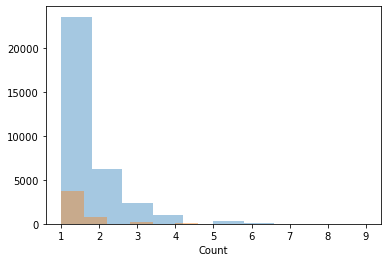

In [68]:
sns.distplot(readmission_data[readmission_data['IsReadmitted']==0]['Count'], kde=False, bins=10)
sns.distplot(readmission_data[readmission_data['IsReadmitted']==1]['Count'], kde=False, bins=10)

In [69]:
# Dropping columns that have served their purpose
selected_data.drop([#'Next_Admission_Date',
       'Readmission_Day_Count'], axis=1, inplace=True)

In [70]:
selected_data.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_PRCDR_CD_1', 'PRVDR_NUM_CAT',
       'ADMTNG_ICD9_DGNS_CD_CAT', 'ICD9_DGNS_CD_1_CAT', 'ICD9_DGNS_CD_2_CAT',
       'ICD9_DGNS_CD_3_CAT', 'ICD9_DGNS_CD_4_CAT', 'ICD9_DGNS_CD_5_CAT',
       'ICD9_DGNS_CD_6_CAT', 'ICD9_DGNS_CD_7_CAT', 'ICD9_DGNS_CD_8_CAT',
       'ICD9_DGNS_CD_9_CAT', 'ICD9_PRCDR_CD_1_CAT', 'CLAIM_YEAR',
       'Next_CLM_ADMSN_DT', 'IsReadmitted'],
      dtype='object')

In [71]:
selected_data.sort_values(by=["DESYNPUF_ID", "NCH_BENE_DSCHRG_DT"], ascending=True, inplace=True)

In [72]:
readmitted_patients_data = selected_data.loc[(selected_data['IsReadmitted']==1), :]


In [73]:
readmitted_patients = readmitted_patients_data.loc[:, 'DESYNPUF_ID'].unique()

In [74]:
drop_index = selected_data.loc[(selected_data['DESYNPUF_ID'].isin(readmitted_patients)) & (selected_data['IsReadmitted']==0)].index

In [75]:
selected_data.drop(index=drop_index, axis=0, inplace=True)

In [76]:
readmitted_patients_data = selected_data.loc[(selected_data['IsReadmitted']==1), :]
not_readmitted_patients_data = selected_data.loc[(selected_data['IsReadmitted']==0), :]

In [77]:
#not_readmitted_patients_data.drop_duplicates(subset=["DESYNPUF_ID", "IsReadmitted"], keep='last', inplace=True)

In [78]:
final_inpatient_data = pd.concat([readmitted_patients_data, not_readmitted_patients_data], axis=0)

In [79]:
# Distribution of readmission vs no readmission
final_inpatient_data['IsReadmitted'].value_counts()/final_inpatient_data.shape[0]

0    0.866479
1    0.133521
Name: IsReadmitted, dtype: float64

In [80]:
final_inpatient_data.loc[(selected_data['IsReadmitted']==0) , ["DESYNPUF_ID", "NCH_BENE_DSCHRG_DT", "IsReadmitted"]]

,DESYNPUF_ID,NCH_BENE_DSCHRG_DT,IsReadmitted
3,0000525AB30E4DEF,2008-06-05,0
4,0000525AB30E4DEF,2008-09-24,0
10,000433285C8D2349,2009-05-24,0
11,0007DC6720F658B7,2009-12-18,0
14,0009EB553C103F95,2008-11-09,0
...,...,...,...
66489,FFFCF02B3CE4D724,2009-01-11,0
66490,FFFCF02B3CE4D724,2009-05-24,0
66491,FFFE94CBE61C0479,2008-03-17,0
66492,FFFE94CBE61C0479,2008-06-17,0


In [81]:
# Distribution of readmission vs no readmission
final_inpatient_data['IsReadmitted'].value_counts()/final_inpatient_data.shape[0]

0    0.866479
1    0.133521
Name: IsReadmitted, dtype: float64

# Dropping all the ICD code columns

In [82]:
final_inpatient_data.drop(columns=icd_procedural_code + diagnosis_code, inplace=True)

In [83]:
final_inpatient_data.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'CLM_ADMSN_DT', 'CLM_PASS_THRU_PER_DIEM_AMT',
       'NCH_BENE_IP_DDCTBL_AMT', 'NCH_BENE_PTA_COINSRNC_LBLTY_AM',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM', 'CLM_UTLZTN_DAY_CNT',
       'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD', 'PRVDR_NUM_CAT',
       'ADMTNG_ICD9_DGNS_CD_CAT', 'ICD9_DGNS_CD_1_CAT', 'ICD9_DGNS_CD_2_CAT',
       'ICD9_DGNS_CD_3_CAT', 'ICD9_DGNS_CD_4_CAT', 'ICD9_DGNS_CD_5_CAT',
       'ICD9_DGNS_CD_6_CAT', 'ICD9_DGNS_CD_7_CAT', 'ICD9_DGNS_CD_8_CAT',
       'ICD9_DGNS_CD_9_CAT', 'ICD9_PRCDR_CD_1_CAT', 'CLAIM_YEAR',
       'Next_CLM_ADMSN_DT', 'IsReadmitted'],
      dtype='object')

In [84]:
final_inpatient_data.to_sql("Inpatient_claims_2", con=conn_object, if_exists="replace", index=False)

In [85]:
conn_object.close()

In [86]:
final_inpatient_data['DESYNPUF_ID'].nunique()

33559

In [87]:
# data_inpatient_claims_2['ICD9_DGNS_CD_1_DESC']

# data_inpatient_claims_2[['DESYNPUF_ID', 'PRVDR_NUM', 'ADMTNG_ICD9_DGNS_CD_DESC']].drop_duplicates()

# data_inpatient_claims_2.shape

# data_inpatient_claims_2.groupby(['DESYNPUF_ID', 'PRVDR_NUM']).size()

# data_inpatient_claims_2

In [88]:
# # Depression = ['300.41', '300.42', '300.43', '300.44', '300.45', '300.46', '300.47', '300.48', '300.49', '301.12', '309', '311']
# # Diabetes = ['249', '250', '357.2', '362.01', '362.02', '366.41']
# # High_Cholesterol = ['272']
# # Angina_Pectoris = ['413']
# # Cardiac_arrest = ['427.5']
# # Hypertension = ['401']
# # Heart_failure = ['398.91', '402.01', '402.11', '402.91','428', '428.9', '404.01', '404.11', '404.91', '404.03', '404.13', '404.93']
# Depression = ['300', '309', '311']
# Diabetes = ['249', '250', '357', '362', '362', '366']
# High_Cholesterol = ['272']
# Angina_Pectoris = ['413']
# Cardiac_arrest = ['427']
# Hypertension = ['401']
# Heart_failure = ['398', '402', '428', '404']

# # Ischemic_Heart_Disease = ['410.00', '410.01', '410.02', '410.10', '410.11', '410.12', '410.20', '410.21', '410.22', '410.30', '410.31', '410.32', '410.40', '410.41', '410.42', '410.50', '410.51', '410.52', '410.60', '410.61', '410.62', '410.70', '410.71', '410.72', '410.80', '410.81', '410.82', '410.90', '410.91', '410.92', '411.0', '411.1', '411.81', '411.89', '412', '413.0', '413.1', '413.9', '414.00', '414.01', '414.02', '414.03', '414.04', '414.05', '414.06', '414.07', '414.10', '414.11', '414.12', '414.19', '414.2', '414.3', '414.8', '414.9']
# Ischemic_Heart_Disease = ['410', '411', '412', '413', '414']

# # CAD = ['414.81', '414.82', '414.83', '414.84', '414.85', '414.86', '414.87', '414.88', '414.89', '414.91', '414.92', '414.93', '414.94', '414.95', '414.96', '414.97', '414.98', '414.99', 'V45.81', 'V45.82']
# CAD = ['V45']

# # unique_diagnosis_code['Diagnosis_code_format'] = unique_diagnosis_code['Diagnosis_code'].apply(lambda d : d[ : 3] + '.' + d[3 : ])

# def group_diagnosis_code(code) :
#     searchCode = code[ : 3]
#     if searchCode in Depression:
#         return 'Depression'
#     elif searchCode in Diabetes:
#         return 'Diabetes'
#     elif searchCode in High_Cholesterol:
#         return 'High Cholesterol'
#     elif searchCode in Angina_Pectoris:
#         return 'Angina Pectoris'
#     elif searchCode in Cardiac_arrest:
#         return 'Cardiac arrest'
#     elif searchCode in Hypertension:
#         return 'Hypertension'
#     elif searchCode in Heart_failure:
#         return 'Heart failure'
#     elif searchCode in Ischemic_Heart_Disease:
#         return 'Ischemic Heart Disease'
#     elif searchCode in CAD:
#         return 'CAD'
#     else :
#         return unique_diagnosis_code[unique_diagnosis_code['Diagnosis_code'] == code]['description'].values[0]

# data_inpatient_claims_2['ADMTNG_ICD9_DGNS_CD_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_1_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_2_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_3_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_4_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_5_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_6_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_7_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_8_DESC'] = np.nan
# data_inpatient_claims_2['ICD9_DGNS_CD_9_DESC'] = np.nan

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ADMTNG_ICD9_DGNS_CD'].notna(), "ADMTNG_ICD9_DGNS_CD_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ADMTNG_ICD9_DGNS_CD'].notna()]["ADMTNG_ICD9_DGNS_CD"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_1'].notna(), "ICD9_DGNS_CD_1_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_1'].notna()]["ICD9_DGNS_CD_1"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_2'].notna(), "ICD9_DGNS_CD_2_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_2'].notna()]["ICD9_DGNS_CD_2"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_3'].notna(), "ICD9_DGNS_CD_3_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_3'].notna()]["ICD9_DGNS_CD_3"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_4'].notna(), "ICD9_DGNS_CD_4_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_4'].notna()]["ICD9_DGNS_CD_4"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_5'].notna(), "ICD9_DGNS_CD_5_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_5'].notna()]["ICD9_DGNS_CD_5"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_6'].notna(), "ICD9_DGNS_CD_6_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_6'].notna()]["ICD9_DGNS_CD_6"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_7'].notna(), "ICD9_DGNS_CD_7_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_7'].notna()]["ICD9_DGNS_CD_7"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_8'].notna(), "ICD9_DGNS_CD_8_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_8'].notna()]["ICD9_DGNS_CD_8"].apply(lambda x : group_diagnosis_code(x))

# data_inpatient_claims_2.loc[data_inpatient_claims_2['ICD9_DGNS_CD_9'].notna(), "ICD9_DGNS_CD_9_DESC"] = data_inpatient_claims_2[data_inpatient_claims_2['ICD9_DGNS_CD_9'].notna()]["ICD9_DGNS_CD_9"].apply(lambda x : group_diagnosis_code(x))

In [89]:
# diagnosis_code_df = pd.DataFrame()

# data_inpatient_claims["ICD9_DGNS_CD_1"].value_counts()

# data_inpatient_claims_2["ICD9_DGNS_CD_1"].value_counts()

# # Common disease for patient
# data_inpatient_claims.groupby(['DESYNPUF_ID', "ADMTNG_ICD9_DGNS_CD"]).size().sort_values(ascending=False)

# # Common disease for patient
# data_inpatient_claims_2.groupby(['DESYNPUF_ID', "ADMTNG_ICD9_DGNS_CD"]).size().sort_values(ascending=False)

# data_inpatient_claims[(data_inpatient_claims['ICD9_DGNS_CD_1'].isin(["39891", "4280", "4281", "42820", "42821", "42822", "42823", "42830", "42831", "42832", "42833", "42840", "42841", "42842", "42843", "4289", "78650", "78651", "78659", "39891", "4280", "4281", "42820", "42821", "42822", "42823", "42830", "42831", "42832", "42833", "42840", "42841", "42842", "42843", "4289"]))]

# for col in diagnosis_code:
#     diagnosis_code_df = pd.concat([diagnosis_code_df, pd.DataFrame(data_inpatient_claims[col].values)], axis=0)

# diagnosis_code_df[0].value_counts()

# unique_diagnosis_code = pd.DataFrame(diagnosis_code_df[0].unique(), columns=['Diagnosis_code'])

# unique_diagnosis_code.dropna(axis=0, inplace=True)

# # unique_diagnosis_code['description'] = unique_diagnosis_code['Diagnosis_code'].apply(lambda x : fetch_diagnosis.get_description_for_icd_code(codeType="icd9cm", ICD9Codes=x))

# # unique_diagnosis_code.to_sql("ICD9_Code_Mapping", con=conn_object, if_exists='append')

# unique_diagnosis_code = pd.read_sql_query("select * from ICD9_Code_Mapping", con=conn_object)
# unique_diagnosis_code.drop(columns=['index'], inplace=True)